In [2]:

import json
import os
import pandas as pd

from config import settings

In [ ]:
llm_model = "gpt-4.1-nano"

split = "test"
request_dir = f"data/comet/{split}/request"
output_dir = f"data/comet/{split}/response/{llm_model}"

## 1. Prepare Input Batches
fnames = [x for x in os.listdir(request_dir) if ".json" in x]
len(fnames)

47

In [28]:
processed_data = {
    "uid": [],
    "original_idx": [],
    "original_src": [],
    "original_relation": [],
    "original_tgt": [],
    "source": [],
    "character": [],
    "joy": [],
    "trust": [],
    "fear": [],
    "surprise": [],
    "sadness": [],
    "disgust": [],
    "anger": [],
    "anticipation": [],
    "reason": []
}
for fname in fnames:
    with open(os.path.join(request_dir, fname), "r") as f:
        request = json.load(f)
    with open(os.path.join(output_dir, fname), "r") as f:
        response = json.load(f)
        
    # Parse entry
    batch_entries = {}
    for entry in request['entries']:
        batch_entries[entry['uid']] = entry
        
    for original_idx, uid in request['uids'].items():
        processed_data["uid"].append(uid)
        processed_data["original_idx"].append(original_idx)
        
        # Entry
        entry = batch_entries[uid]
        processed_data["original_src"].append(entry['source'])
        processed_data["original_relation"].append(entry['relation'])
        processed_data["original_tgt"].append(entry['target'])
        
        # Result
        result = response[uid]
        processed_data["source"].append(result['source']) 
        processed_data["character"].append(result['character']) 
        for k, v in result['emotion'].items():
            processed_data[k].append(v)
        processed_data["reason"].append(result['reason'])

In [29]:
processed_df = pd.DataFrame.from_dict(processed_data)

In [30]:
print(processed_df.shape, processed_df.columns)
processed_df.head()

(1484, 16) Index(['uid', 'original_idx', 'original_src', 'original_relation',
       'original_tgt', 'source', 'character', 'joy', 'trust', 'fear',
       'surprise', 'sadness', 'disgust', 'anger', 'anticipation', 'reason'],
      dtype='object')


,uid,original_idx,original_src,original_relation,original_tgt,source,character,joy,trust,fear,surprise,sadness,disgust,anger,anticipation,reason
0,ea14b267-ad80-4c0d-8383-d76d37119b9f,87340,PersonX wraps PersonY's arm around PersonY,xReact,"happy, satisfied",Maria was at a friendly gathering where she no...,Maria,medium,high,na,na,na,na,na,low,Maria feels happy and satisfied because her fr...
1,42c090ce-15e8-45e2-b351-50881fedee93,10406,PersonX chooses one 's ___,oReact,that x is bossy,Alex was hesitant as he chose a gift for his b...,Alex,na,medium,low,na,na,na,low,medium,Alex feels somewhat anxious because he worries...
2,c746042b-134c-4b62-9ca4-3e0f8a281bf1,26862,PersonX gets a part,xReact,competent,"Emma received a new role in her team, which ma...",Emma,medium,high,na,na,na,na,na,high,Emma feels competent and confident after succe...
3,c88d7a4b-5c86-454e-aaca-a0ccb6aaf764,65517,PersonX sees PersonY frequently,xReact,happy,Liam sees his best friend frequently walking t...,Liam,medium,high,na,na,na,na,na,low,Liam feels happy because regular visits streng...
4,99bd7636-3159-4c3b-97d3-5616cf3c7ede,52469,PersonX offer PersonY opinion,xReact,interested,Grace offered her colleague an opinion on a pr...,Grace,low,medium,na,na,na,na,na,medium,Grace feels interested because sharing opinion...


In [ ]:
processed_df.to_csv(
    f"data/comet/{split}/sample_result_{llm_model}.csv",
    sep = "\t",
    index=False
)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tiktoken

In [9]:
tokenizer = tiktoken.encoding_for_model('gpt-4o')
def calculate_tokens(text):
    tokens = tokenizer.encode(text)
    return len(tokens)

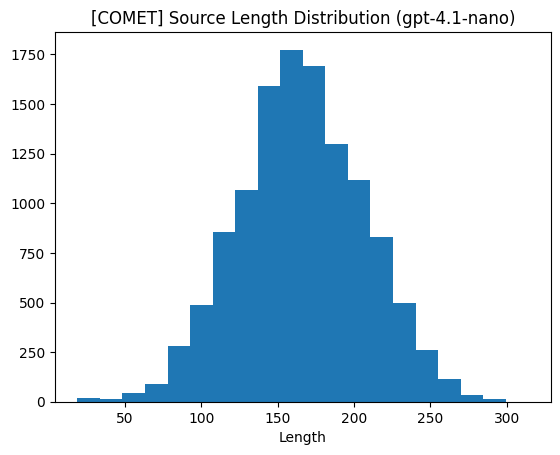

In [10]:
source_lens = [len(x) for x in processed_df['source']]
plt.hist(source_lens, bins = 20)
plt.title(f'[COMET] Source Length Distribution ({llm_model})')
plt.xlabel('Length')
plt.show()

In [11]:
np.array(source_lens).mean(), np.array(source_lens).min()

(165.65334549374015, 19)

In [13]:
row = processed_df.iloc[0]
print(row['character'])
print(row['source'])

Nathan
Nathan lost the chess match during the local tournament, feeling disappointed and frustrated with himself for not playing well enough. His friends tried to comfort him afterward. Nathan sat quietly, contemplating what went wrong.


# Format as Instruction Format

In [18]:
from transformers import AutoTokenizer

model_name = "microsoft/phi-4"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.25M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

In [14]:
system_message = '''
You are building an emotion‑prediction component that, given a character name and a brief situational description, must identify the character’s emotional state and the reason for it.

When given an input of the form:
```
Character:  {character}
Source: {source}
```
your job is to:

1. **Map the Emotion:**  
   - Choose among the 8 primary emotions from Plutchik’s Wheel (joy, trust, fear, surprise, sadness, disgust, anger, anticipation).  
   - For each, assign one of: `"na"` (not applicable), `"low"`, `"medium"`, or `"high"`.

2. **Write a Reason:**  
   - Provide a single sentence explaining why the character feels as you’ve labeled.

## Map the Emotion: Map the target emotion onto the 8 primary emotions from Plutchik’s Wheel
* Joy
* Trust
* Fear
* Surprise
* Sadness
* Disgust
* Anger
* Anticipation

For each emotion, assign one of the following intensities:
* "na" (not applicable)
* "low"
* "medium"
* "high"

Interpret the target emotion (e.g., “authoritative”) in terms of Plutchik’s emotions. For example, you might decide:
* trust: high
* joy: low
* anticipation: medium

## Write a Reason:
Provide a one-sentence rationale ("reason") explaining why the subject (if xReact) or the other person (if oReact) feels the given emotion(s).
ex. “She feels empowered and confident after cutting out social media.”


Return in the following JSON format (no extra keys, no explanation outside the JSON)
{
    "emotion": {
        "joy": "na" | "low" | "medium" | "high",
        "trust": "na" | "low" | "medium" | "high",
        "fear": "na" | "low" | "medium" | "high",
        "surprise": "na" | "low" | "medium" | "high",
        "sadness": "na" | "low" | "medium" | "high",
        "disgust": "na" | "low" | "medium" | "high",
        "anger": "na" | "low" | "medium" | "high",
        "anticipation": "na" | "low" | "medium" | "high"
    },
    "reason": "One sentence explaining why these emotions occur"
}
Only return the JSON'''

user_template = '''Source: {source}
Character: {character}'''


In [19]:
# Test Formatting
row = processed_df.iloc[0]

user_message = user_template.format(
    source=row['source'],
    character=row['character']
)

assistant_message = json.dumps(
    {
        "emotion": {
            "joy": row['joy'],
            "trust": row['trust'],
            "fear": row['fear'],
            "surprise": row['surprise'],
            "sadness": row['sadness'],
            "disgust": row['disgust'],
            "anger": row['anger'],
            "anticipation": row['anticipation']
        },
        "reason": row['reason']
    }
)
messages = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": user_message},
    {"role": "assistant", "content": assistant_message}
]
source = tokenizer.apply_chat_template(messages, tokenize = False)

In [21]:
import pprint
pprint.pprint(source)

('<|im_start|>system<|im_sep|>\n'
 'You are building an emotion‑prediction component that, given a character '
 'name and a brief situational description, must identify the character’s '
 'emotional state and the reason for it.\n'
 '\n'
 'When given an input of the form:\n'
 '```\n'
 'Character:  {character}\n'
 'Source: {source}\n'
 '```\n'
 'your job is to:\n'
 '\n'
 '1. **Map the Emotion:**  \n'
 '   - Choose among the 8 primary emotions from Plutchik’s Wheel (joy, trust, '
 'fear, surprise, sadness, disgust, anger, anticipation).  \n'
 '   - For each, assign one of: `"na"` (not applicable), `"low"`, `"medium"`, '
 'or `"high"`.\n'
 '\n'
 '2. **Write a Reason:**  \n'
 '   - Provide a single sentence explaining why the character feels as you’ve '
 'labeled.\n'
 '\n'
 '## Map the Emotion: Map the target emotion onto the 8 primary emotions from '
 'Plutchik’s Wheel\n'
 '* Joy\n'
 '* Trust\n'
 '* Fear\n'
 '* Surprise\n'
 '* Sadness\n'
 '* Disgust\n'
 '* Anger\n'
 '* Anticipation\n'
 '\n